In [1]:

###
### code descriptions
###

# 1. load qwen model
# 2. define message format
# 3. generate several times

###
### package requirements
###

# # essential
# torch>=2.0.0
# torchvision>=0.15.0
# qwen-vl-utils>=0.0.8
# accelerate>=1.8.1
# transformers>=4.53.0

# # I think don't need below
# einops>=0.6.0
# numpy>=1.24.0
# Pillow>=9.5.0
# huggingface-hub>=0.16.0

###
### load models
###

from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info

# default: Load the model on the available device(s)
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-3B-Instruct", torch_dtype="auto", device_map="auto"
)

# We recommend enabling flash_attention_2 for better acceleration and memory saving, especially in multi-image and video scenarios.
# model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
#     "Qwen/Qwen2.5-VL-3B-Instruct",
#     torch_dtype=torch.bfloat16,
#     attn_implementation="flash_attention_2",
#     device_map="auto",
# )

# default processer
processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct")

# The default range for the number of visual tokens per image in the model is 4-16384.
# You can set min_pixels and max_pixels according to your needs, such as a token range of 256-1280, to balance performance and cost.
# min_pixels = 256*28*28
# max_pixels = 1280*28*28
# processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct", min_pixels=min_pixels, max_pixels=max_pixels)

###
### set up message and image data
###

messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": "http://images.cocodataset.org/val2017/000000039769.jpg",
            },
            {"type": "text", "text": "Describe this image."},
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

###
### run several times
###

sample_texts = []

for _ in range(5):

    # Inference: Generation of the output
    generated_ids = model.generate(**inputs, max_new_tokens=128)
    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    print(output_text)

    sample_texts.append(output_text)

ImportError: cannot import name 'Qwen2_5_VLForConditionalGeneration' from 'transformers' (/home/tsujimura/work/anaconda3/envs/mlx802/lib/python3.11/site-packages/transformers/__init__.py)

In [2]:
import pandas as pd

In [3]:
df_img = pd.read_csv("../../img/our_img_database/image_descriptions.csv")
df_img

img_file  \
0         IMG-20240830-WA0035.jpg   
1      PXL_20240808_144210762.jpg   
2      PXL_20240814_193607785.jpg   
3   PXL_20240817_153710097.MP.jpg   
4      PXL_20240903_115821903.jpg   
..                            ...   
62     PXL_20250630_143105978.jpg   
63     PXL_20250630_160301403.jpg   
64     PXL_20250630_233147702.jpg   
65  PXL_20250630_233148717.MP.jpg   
66     PXL_20250701_071140225.jpg   

                                          description  
0   The image depicts a large, shaggy-haired anima...  
1   The image shows a grand, classical architectur...  
2   The image depicts a serene and rugged landscap...  
3   The image depicts an urban scene with a promin...  
4   The image shows an outdoor scene with a focus ...  
..                                                ...  
62  The image depicts a modern, well-lit room with...  
63  The image shows a person standing in front of ...  
64  The image depicts an architectural structure f...  
65  The image depicts an archway or entrance to a ...  
66  The image shows a close-up of a white ceramic ...  

[67 rows x 2 columns]

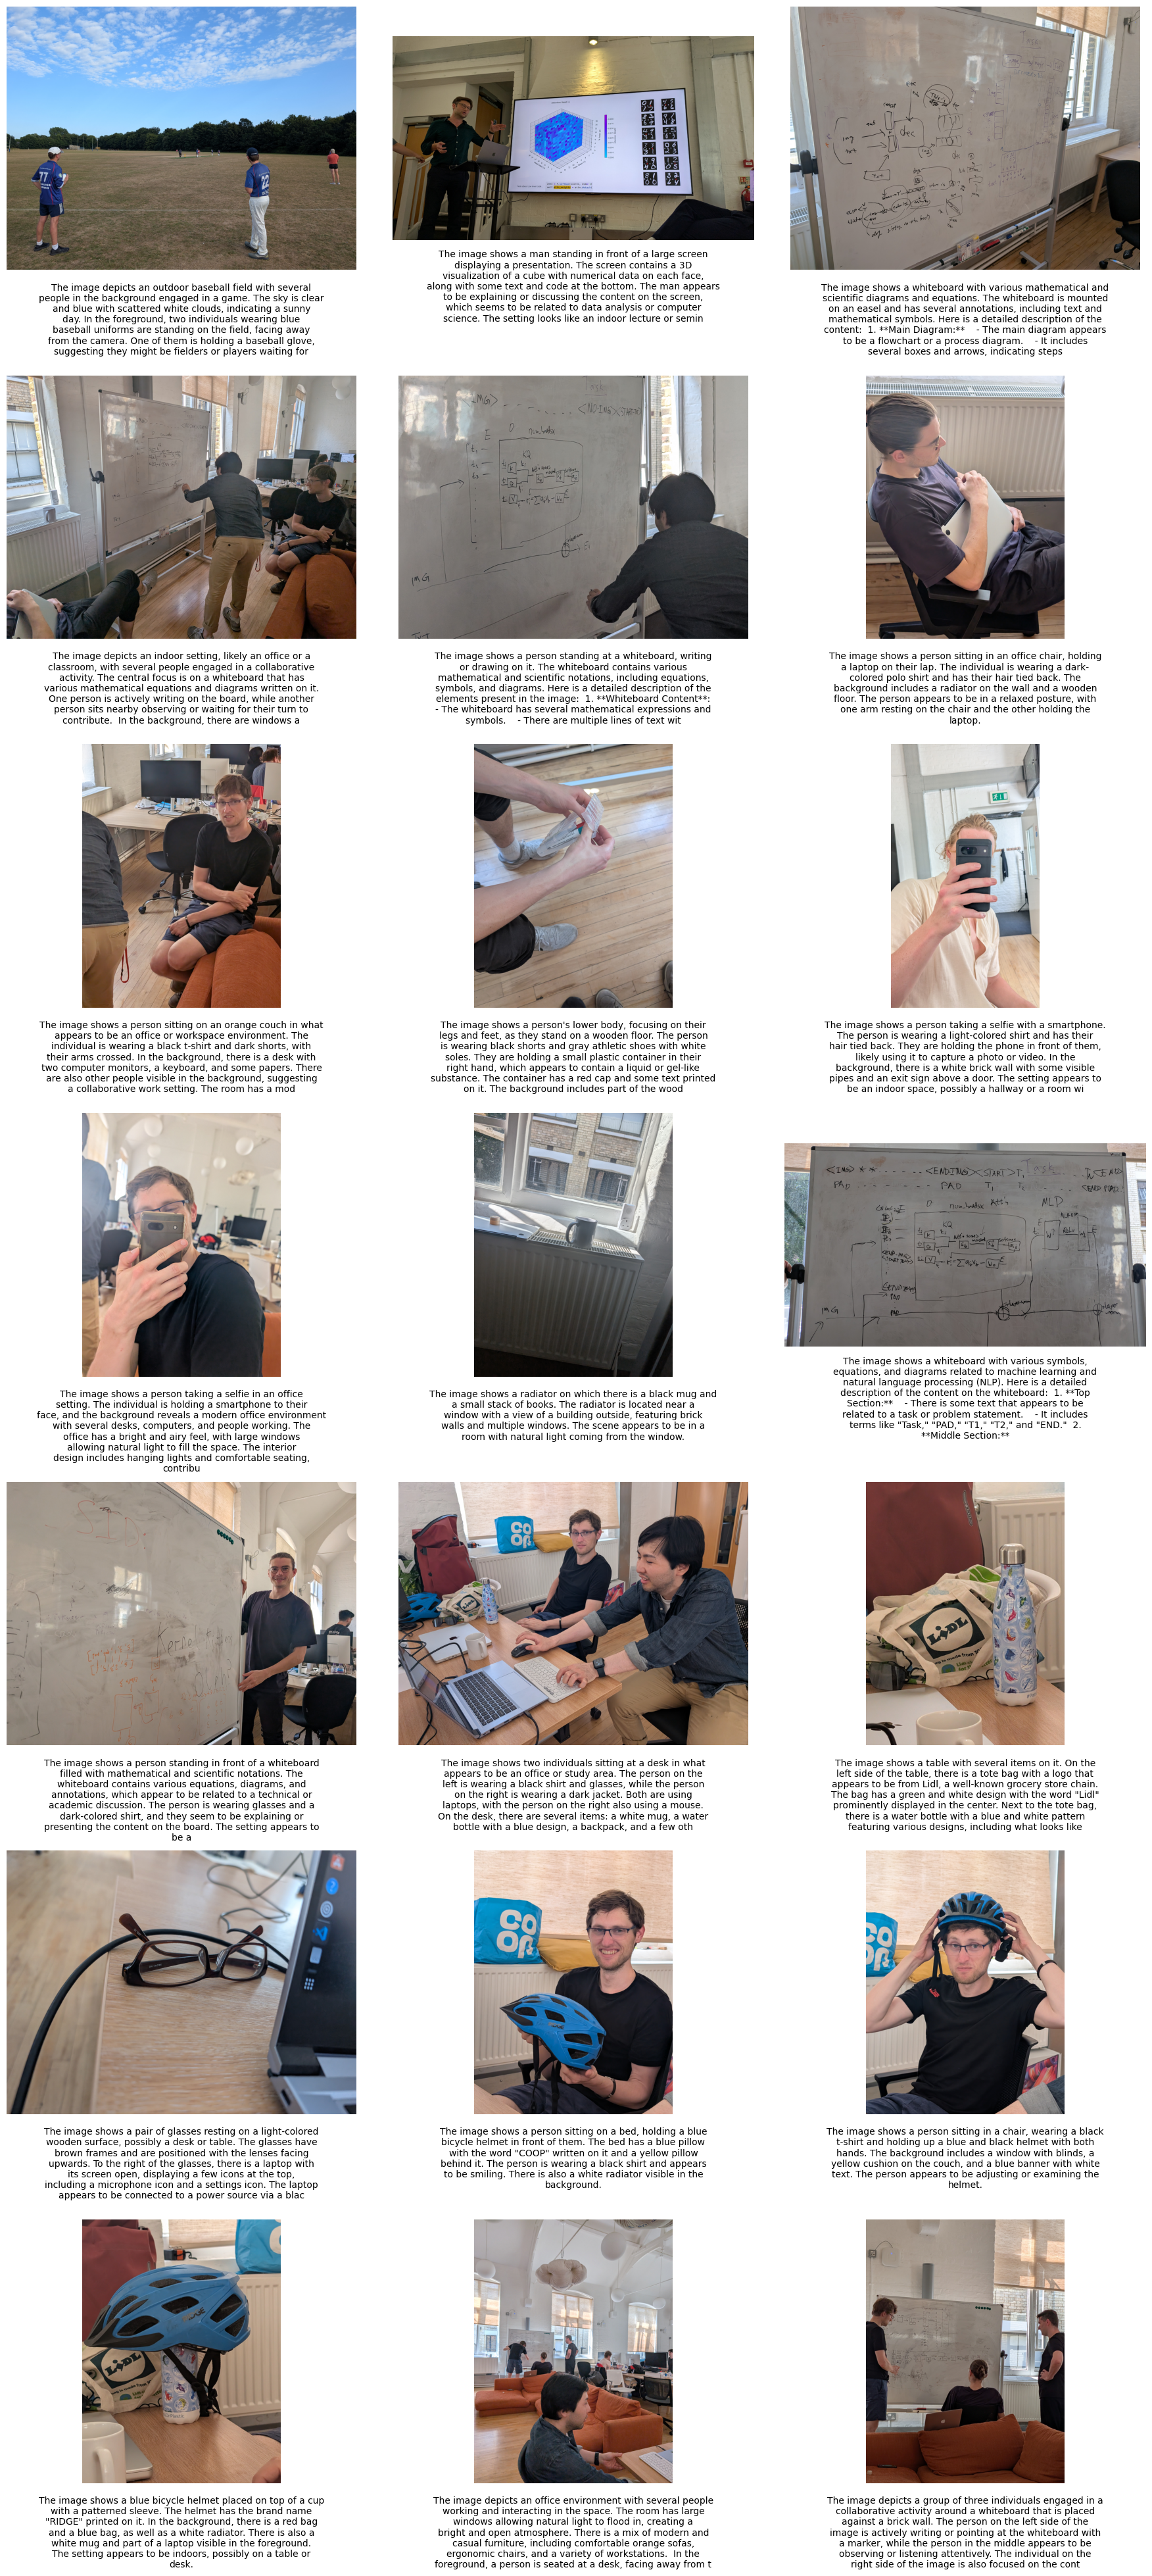

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import textwrap

rt_path = "../../img/our_img_database/"

# Configuration
df_subset = df_img.loc[40:60]
n_images = len(df_subset)
n_cols = 3
n_rows = (n_images + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows))
axes = axes.flatten()

for i, (idx, row) in enumerate(df_subset.iterrows()):
    img_path = os.path.join(rt_path, "Dropouts", row["img_file"])
    description = row["description"][:400]

    # Load image
    img = mpimg.imread(img_path)
    axes[i].imshow(img)
    axes[i].axis('off')

    # Wrap long description to avoid overflow
    wrapped_text = "\n".join(textwrap.wrap(description, width=60)) # for each 70th word, add \n so that create a new line
    axes[i].text(
        0.5, -0.05, wrapped_text,
        ha='center', va='top', transform=axes[i].transAxes,
        fontsize=10
    )

# Hide unused axes
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.subplots_adjust(bottom=0.1, hspace=0.4)
plt.show()
